<a href="https://colab.research.google.com/github/anaguilarar/agwise_data_sourcing/blob/main/GEEMODIS_data_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### INITIAL configuration

configuration = {
    'GENERAL_SETTINGS':{
      'ee_project_name': 'ee-anaguilarar'

      },
    'PREPROCESSING':{
        'crop_mask': True,
        'crop_mask_product': 'ESA'
    },
    'DATA_DOWNLOAD':
     {
      'ADM0_NAME': 'Kenya',
      'ADM1_NAME': 'Coast',
      'ADM2_NAME': None,
      'product': 'MOD13Q1',
      'starting_date': '2023-01-01',
      'ending_date': '2023-12-01',

    }
}


In [2]:
import os

if not os.path.exists('agwise_data_sourcing'):
  !git clone https://github.com/anaguilarar/agwise_data_sourcing.git
  os.chdir('/content/agwise_data_sourcing')
else:
  os.chdir('/content/agwise_data_sourcing')


Cloning into 'agwise_data_sourcing'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 19 (delta 3), reused 11 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 97.64 KiB | 1.55 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
from gee_datasets.gee_data import GEEMODIS
import ee
ee.Initialize(project=configuration['GENERAL_SETTINGS']['ee_project_name'])


In [5]:
data_downloader = GEEMODIS(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['DATA_DOWNLOAD']['product'])
data_downloader.initialize_query(configuration['DATA_DOWNLOAD']['starting_date'], configuration['DATA_DOWNLOAD']['ending_date'])


[{'type': 'Feature', 'geometry': None, 'id': '2023_01_01', 'properties': {'NDVI': 3399.1486780787563, 'date': '2023-01-01T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_01_17', 'properties': {'NDVI': 3191.4627656399834, 'date': '2023-01-17T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_02_02', 'properties': {'NDVI': 2829.8045550135585, 'date': '2023-02-02T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_02_18', 'properties': {'NDVI': 2700.169533737636, 'date': '2023-02-18T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_03_06', 'properties': {'NDVI': 2645.990747371075, 'date': '2023-03-06T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_03_22', 'properties': {'NDVI': 3413.3495330551355, 'date': '2023-03-22T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_04_07', 'properties': {'NDVI': 4451.494989720906, 'date': '2023-04-07T00:00:00'}}, {'type': 'Feature', 'geometry': None, 'id': '2023_04_23', 'prope

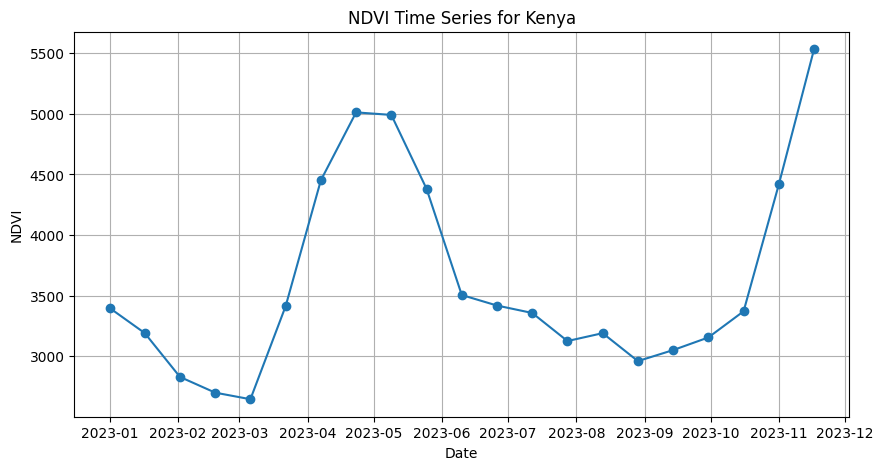

,date,NDVI
0,2023-01-01,3399.148678
1,2023-01-17,3191.462766
2,2023-02-02,2829.804555
3,2023-02-18,2700.169534
4,2023-03-06,2645.990747
5,2023-03-22,3413.349533
6,2023-04-07,4451.494990
7,2023-04-23,5011.517496
8,2023-05-09,4990.488823
9,2023-05-25,4381.384597


In [6]:
data_downloader.plot_time_series('NDVI')

In [7]:
from gee_datasets.processing_funs import fill_gaps_linear, smooth_ts_using_savitsky_golay_modis, summarize_collection_tots
import matplotlib.pyplot as plt

data_filled = fill_gaps_linear(data_downloader.query, 'NDVI')

print("First smoothed image properties:",
      ee.Image(data_filled.first()).getInfo()["properties"])



First smoothed image properties: {'system:time_start': 1672531200000, 'google:max_source_file_timestamp': 1674237758000, 'num_tiles': 286, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:time_end': 1673913600000, 'system:asset_size': 29616439319, 'system:index': '2023_01_01'}


In [8]:
band = 'NDVI'
result = smooth_ts_using_savitsky_golay_modis(data_filled.select('NDVI'), window_size = 5)
print("First smoothed image properties:",
      ee.Image(result.first()).getInfo()["properties"])


First smoothed image properties: {'system:time_start': 1675296000000, 'system:index': '0'}


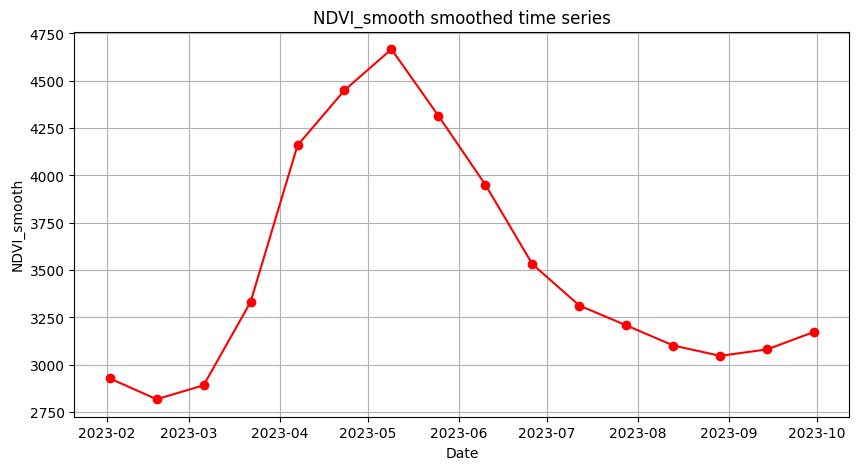

In [9]:
from utils.plots import plot_time_series_from_ic

band2 = 'NDVI_smooth'

df = plot_time_series_from_ic(
    ic=ee.ImageCollection(result),
    band=band2,
    summarize_fn=summarize_collection_tots,
    region_filter=data_downloader.country_filter,
    title=f"{band2} smoothed time series"
)


## CROP MASK

In [10]:
from gee_datasets.gee_data import GEECropMask, GEEMODIS


data_downloader = GEEMODIS(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['DATA_DOWNLOAD']['product'])
data_downloader.initialize_query(configuration['DATA_DOWNLOAD']['starting_date'], configuration['DATA_DOWNLOAD']['ending_date'])


cropmask_downloader = GEECropMask(configuration['DATA_DOWNLOAD']['ADM0_NAME'], configuration['PREPROCESSING']['crop_mask_product'])
cropmask_downloader.initialize_query()

crop_mask = ee.Image(cropmask_downloader.query.first()).clip(cropmask_downloader.country_filter).eq(cropmask_downloader.crop_mask_value[cropmask_downloader.product])



In [11]:
from gee_datasets.processing_funs import fill_gaps_linear, smooth_ts_using_savitsky_golay_modis, summarize_collection_tots

data_filled = fill_gaps_linear(data_downloader.query, 'NDVI')


datamasked = data_downloader.query.first().clip(cropmask_downloader.country_filter).updateMask(crop_mask)

data_filled_masked = data_filled.first().clip(cropmask_downloader.country_filter).updateMask(crop_mask)

data_filled_SG = smooth_ts_using_savitsky_golay_modis(data_filled.select('NDVI'), window_size = 5)


data_filled_SG_masked = data_filled_SG.first().clip(cropmask_downloader.country_filter).updateMask(crop_mask)

In [12]:
import geemap


# Create a map
Map = geemap.Map(center=[-1.37, 38.01], zoom=8)  # Centered on Kitui, Kenya (example coords)

# Define visualization parameters
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']  # Adjust based on your mask values
}

vis_NDVIparams = {
    'min': 0,
    'max': 10000,

}

# Add the image layer
Map.addLayer(crop_mask, vis_params, "Masked Crop Image")

Map.addLayer(datamasked.select('NDVI'), vis_NDVIparams, "NDVI Image")
Map.addLayer(data_filled_masked.select('NDVI'), vis_NDVIparams, "NDVI Image filled")
Map.addLayer(data_filled_SG_masked.select('NDVI_smooth'), vis_NDVIparams, "NDVI Image filled + SG")

# Display the map
Map

Map(center=[-1.37, 38.01], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…